# Tutorial Notebook
This is a tutorial notebook that goes through the GRIP-Tomo 2.0 pipeline for converting MRC format cryo-ET sub-tomograms into clusters, graphs, and graph features, then using the graph features to perform machine learning classifications. 

The MRC → graph → features results in the manuscript were done using hardware-specific Parsl parallel computing on the NERSC Perlmutter platform. 
The pipeline shown in this tutorial notebook uses a serial example to show how the pipeline works (without Parsl or parallel computing).

# MRC → graph → features
For a single example MRC and feature vector

### Load environment and packages

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import hdbscan
import warnings
from tqdm import tqdm


# import grip-tomo modules
import griptomo.core.pdb2graph as p2g
import griptomo.core.density2graph as d2g
import griptomo.core.graph2class as g2c

# plot settings
plt.rc('axes', axisbelow=True)
px = 1/72

warnings.filterwarnings('ignore')

print('modules imported')

modules imported


### Load MRC format cryo-ET sub-tomogram

In [5]:
# Import the mrc file with the package mrcfile
import mrcfile
mrc = mrcfile.mmap('108-382-131.mrc', mode='r') # apoferritin example mrc file

In [6]:
# store the mrc data (no header, etc.) into a new object
mrc_sliced = mrc.data

In [7]:
# check dimensions of the loaded data
print (mrc_sliced.shape)

(219, 219, 219)


### Preprocessing before constructing the graph

In [ ]:
# Normalization/standardization of densities
normalized_densities = d2g.normalize_mrc_data(mrc_sliced)

In [9]:
# Set and apply a threshold (which is ratio in this notebook, 0.9 means only top 10% densities are preserved) to filter out low density signals
threshold_ratio = 0.9
threshold = d2g.identify_threshold_ratio(normalized_densities, threshold_ratio)
point_cloud = d2g.generate_point_cloud_from_mrc_data(normalized_densities, threshold) 
density_map = normalized_densities[point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2]] + 1
density_map = density_map / 2

In [10]:
# precoarsening the densities
precoarsened_point_cloud, precoarsened_density = d2g.voxel_coarsening(3, point_cloud, np.zeros(point_cloud.shape[0], dtype=np.int64), density_map, averaged=True)

In [11]:
# HDBSCAN clustering
model_clusters = hdbscan.HDBSCAN(min_cluster_size=512, min_samples=512, allow_single_cluster=False, core_dist_n_jobs=-1, approx_min_span_tree=False, cluster_selection_epsilon=0, cluster_selection_method='eom').fit(precoarsened_point_cloud)
labels = model_clusters.labels_

### Construct and save graph at cutoff distance 5 Å as example

In [12]:
import numpy as np
import networkx as nx
from scipy.spatial import KDTree

# Use non-noise points only
coords = precoarsened_point_cloud
labels = model_clusters.labels_

# Filter to valid (non-noise) points
valid_idx = np.where(labels >= 0)[0]
valid_coords = coords[valid_idx]
valid_labels = labels[valid_idx]

# KDTree for valid points
cutoff_distance = 5
tree = KDTree(valid_coords)
G = nx.Graph()

# Add valid nodes with x, y, z, cluster attributes
for i_local, i_global in enumerate(valid_idx):
    x, y, z = coords[i_global]
    G.add_node(i_global, x=float(x), y=float(y), z=float(z), cluster=int(labels[i_global]))

# Add edges among valid nodes based on cutoff distance
for i_local, i_global in enumerate(valid_idx):
    neighbors = tree.query_ball_point(coords[i_global], r=cutoff_distance)
    for j_local in neighbors:
        if i_local < j_local:
            j_global = valid_idx[j_local]
            dist = np.linalg.norm(coords[i_global] - coords[j_global])
            G.add_edge(i_global, j_global, weight=dist)

# Save the graph
nx.write_gexf(G, "./graph_dcut=5.gexf")
print(f"Graph saved with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph saved with 20071 nodes and 124432 edges.


### Calculate features of the graph and print 

In [ ]:
# This may take a few minutes depending on the graph size (more time when graph is large)
G_feat = g2c.igraph_calc_graph_features(G)
print (G_feat)

{'n nodes': 14106.0, 'n edges': 91492.0, 'density': 0.0009196787396866979, 'diameter': 97, 'avg clustering': 0.4992673822878274, 'max closeness centrality': 0.047121433320081646, 'max eigenvector centrality': 0.1308360599223412, 'degree assortativity': 0.741563316369559, 'max clique number': 9, 'n communities': 15, 'avg path length': 29.924585700016884, 'max betweenness centrality': 0.17719938220658}


### Visualize the feature "fingerprint" across multiple cutoff distances
The key to GRIP-Tomo classification is computing features at multiple distance cutoffs (3-15 Å). This creates a characteristic "fingerprint" showing how graph topology evolves with connectivity scale. We'll use the pre-computed multi-cutoff dataset to visualize this pattern for apoferritin.

In [14]:
# Load the multi-cutoff experimental testing dataset (contains apoferritin samples)
from matplotlib.ticker import MultipleLocator

multi_cutoff_data = pd.read_csv('./combined_features_experimental_testing_cleaned_multi_cutoff.csv')

# Filter to apoferritin only and rename category for consistency
multi_cutoff_data['category'] = multi_cutoff_data['category'].replace({'horse-l-apoferritin': 'apoferritin'})
apoferritin_data = multi_cutoff_data[multi_cutoff_data['category'] == 'apoferritin']

# Define the 11 features
feature_names = [
    'n nodes', 'n edges', 'density', 'diameter', 'avg clustering',
    'max closeness centrality', 'max eigenvector centrality', 
    'degree assortativity', 'n communities', 'avg path length', 
    'max betweenness centrality'
]

# Pretty display names
feature_display_names = {
    'n nodes': 'number of nodes',
    'n edges': 'number of edges',
    'avg clustering': 'average clustering',
    'n communities': 'number of communities',
    'avg path length': 'average path length'
}

print(f"Loaded {len(apoferritin_data)} apoferritin samples across multiple cutoffs")
print(f"Cutoff range: {apoferritin_data['cutoff'].min()}-{apoferritin_data['cutoff'].max()} Å")

Loaded 650 apoferritin samples across multiple cutoffs
Cutoff range: 3-15 Å


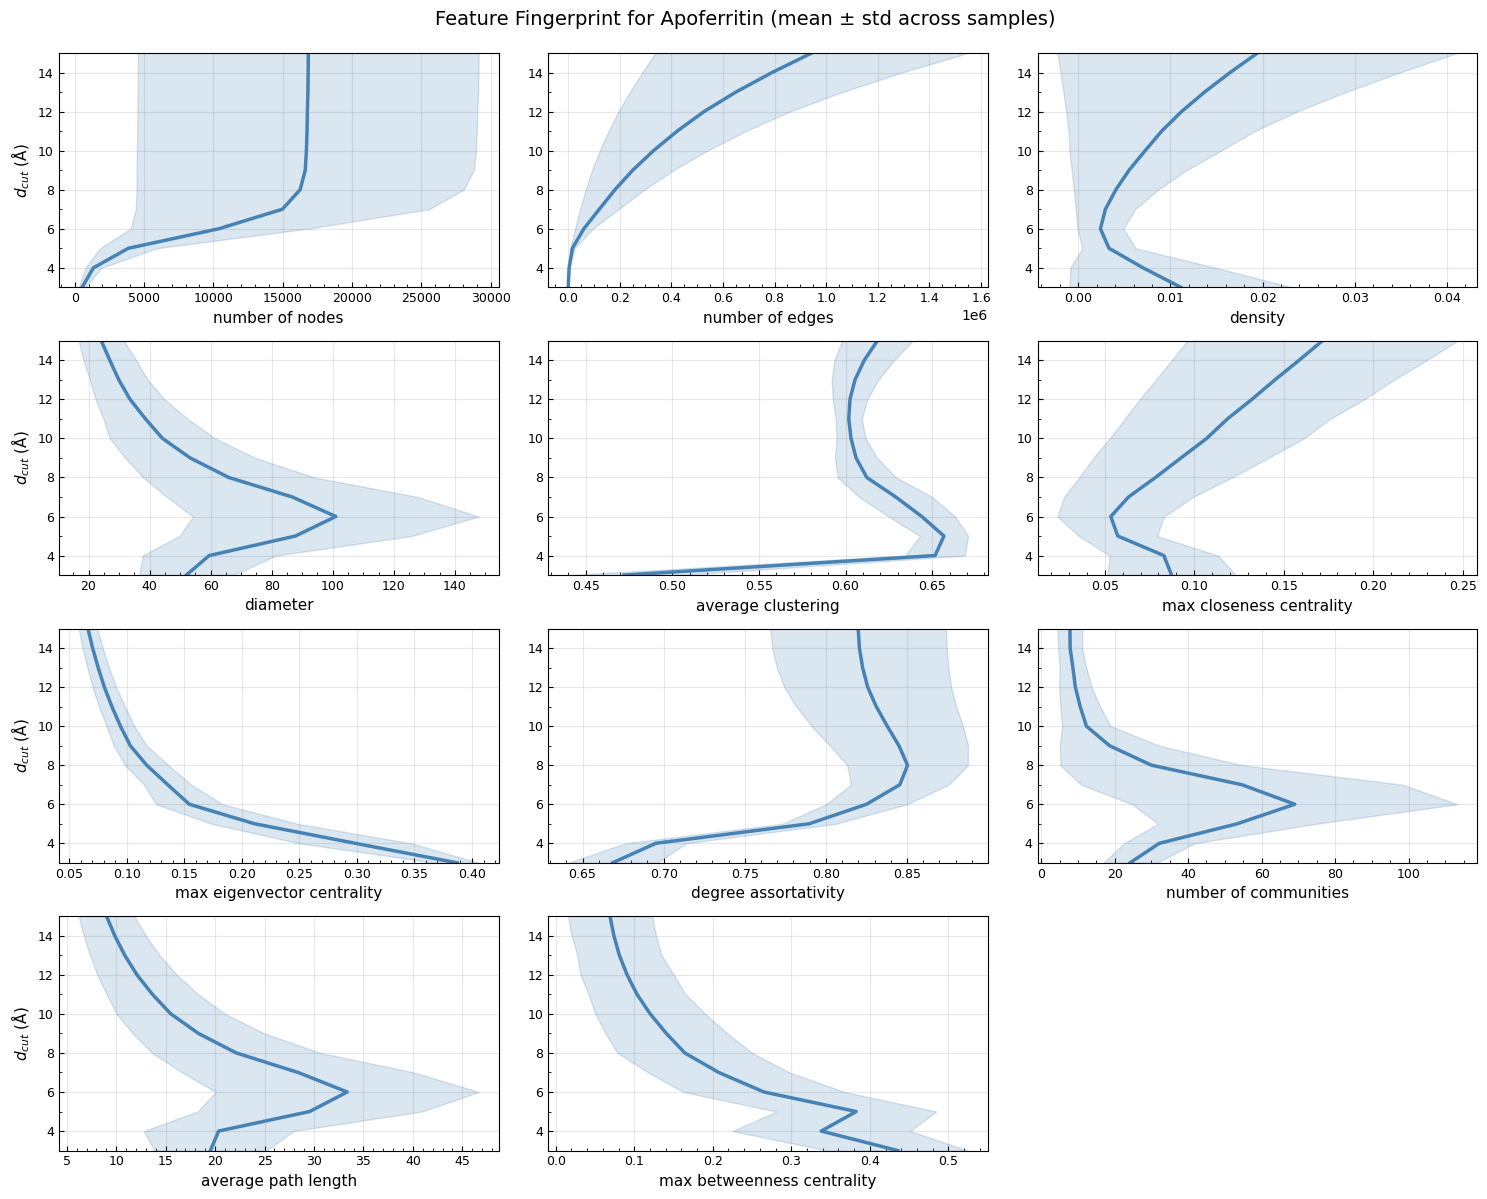


This fingerprint shows the characteristic pattern of how graph topology
changes as we include more distant connections (higher d_cut values).


In [15]:
# Create fingerprint plot: 4×3 grid showing how each feature varies with cutoff distance
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

# Calculate mean and std for each feature across samples at each cutoff
for i, feature in enumerate(feature_names):
    if i >= len(axes):
        break
    
    ax = axes[i]
    
    # Group by cutoff and calculate mean ± std
    summary = apoferritin_data.groupby('cutoff')[feature].agg(['mean', 'std'])
    
    # Plot: feature value (x-axis) vs cutoff distance (y-axis)
    ax.fill_betweenx(summary.index, 
                     summary['mean'] - summary['std'], 
                     summary['mean'] + summary['std'],
                     color='steelblue', alpha=0.2)
    ax.plot(summary['mean'], summary.index, color='steelblue', linewidth=2.5)
    
    # Formatting
    display_name = feature_display_names.get(feature, feature)
    ax.set_xlabel(display_name, fontsize=11)
    
    # Y-axis label only for leftmost column
    if i % 3 == 0:
        ax.set_ylabel('$d_{cut}$ (Å)', fontsize=11)
    
    # Grid and ticks
    ax.grid(alpha=0.3)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in', labelsize=9)
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.set_ylim((3, 15))

# Remove extra subplots
for i in range(len(feature_names), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Feature Fingerprint for Apoferritin (mean ± std across samples)', 
             fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

print("\nThis fingerprint shows the characteristic pattern of how graph topology")
print("changes as we include more distant connections (higher d_cut values).")

# Machine learning classification

#### In this section, a pipeline of machine learning classification is shown using the data obtained from NERSC Perlmutter. The training and testing sets are the combination of graph features of MRC samples at various cutoff distances, i.e., hundreds of feature vectors calculated in the pipeline above.

### Load packages

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

from sklearn.ensemble      import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics       import (
    accuracy_score, f1_score,
    classification_report, confusion_matrix
)

### Plot settings and load data

In [17]:
# Set the font as Arial for all figures
import matplotlib as mpl

#set up the font type as arial
font = {'family' : 'Arial',
#         'weight' : 'light'}
#         'weight' : 'light',
        'size'   : 20}

mpl.rc('font', **font)

sns.set(style='whitegrid')

dpi        = 1000
top_n      = 10

# Load training and testing data
train_path = './combined_features_mock_training_cleaned_concatenated.csv'
test_path  = './combined_features_experimental_testing_cleaned_concatenated.csv'

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

### Merge apoferritin and beta-gal classes into a single 'proteins' class, skip if not binary classification

In [18]:
# Merge the two proteins classes → single “proteins”
mapping = {
    'horse-l-apoferritin': 'proteins',
    'betagal':            'proteins',
}
train_df = train_df[train_df['category'] != 'aldolase']
train_df['category'] = train_df['category'].replace(mapping)
test_df ['category'] = test_df ['category'].replace(mapping)

### Preprocess the dataset

In [19]:
# Split out features & labels
features = [c for c in train_df.columns if c not in ('file_name','category')]
X_train, y_train = train_df[features], train_df['category']
X_test,  y_test  = test_df [features], test_df ['category']

### Train the model

In [20]:
# Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

### Evaluate classification performance and make plots

=== Random Forest ===
Accuracy:    0.8103
Weighted F1: 0.7900

              precision    recall  f1-score   support

       noise       0.90      0.46      0.61        56
    proteins       0.79      0.97      0.87       118

    accuracy                           0.81       174
   macro avg       0.84      0.72      0.74       174
weighted avg       0.83      0.81      0.79       174



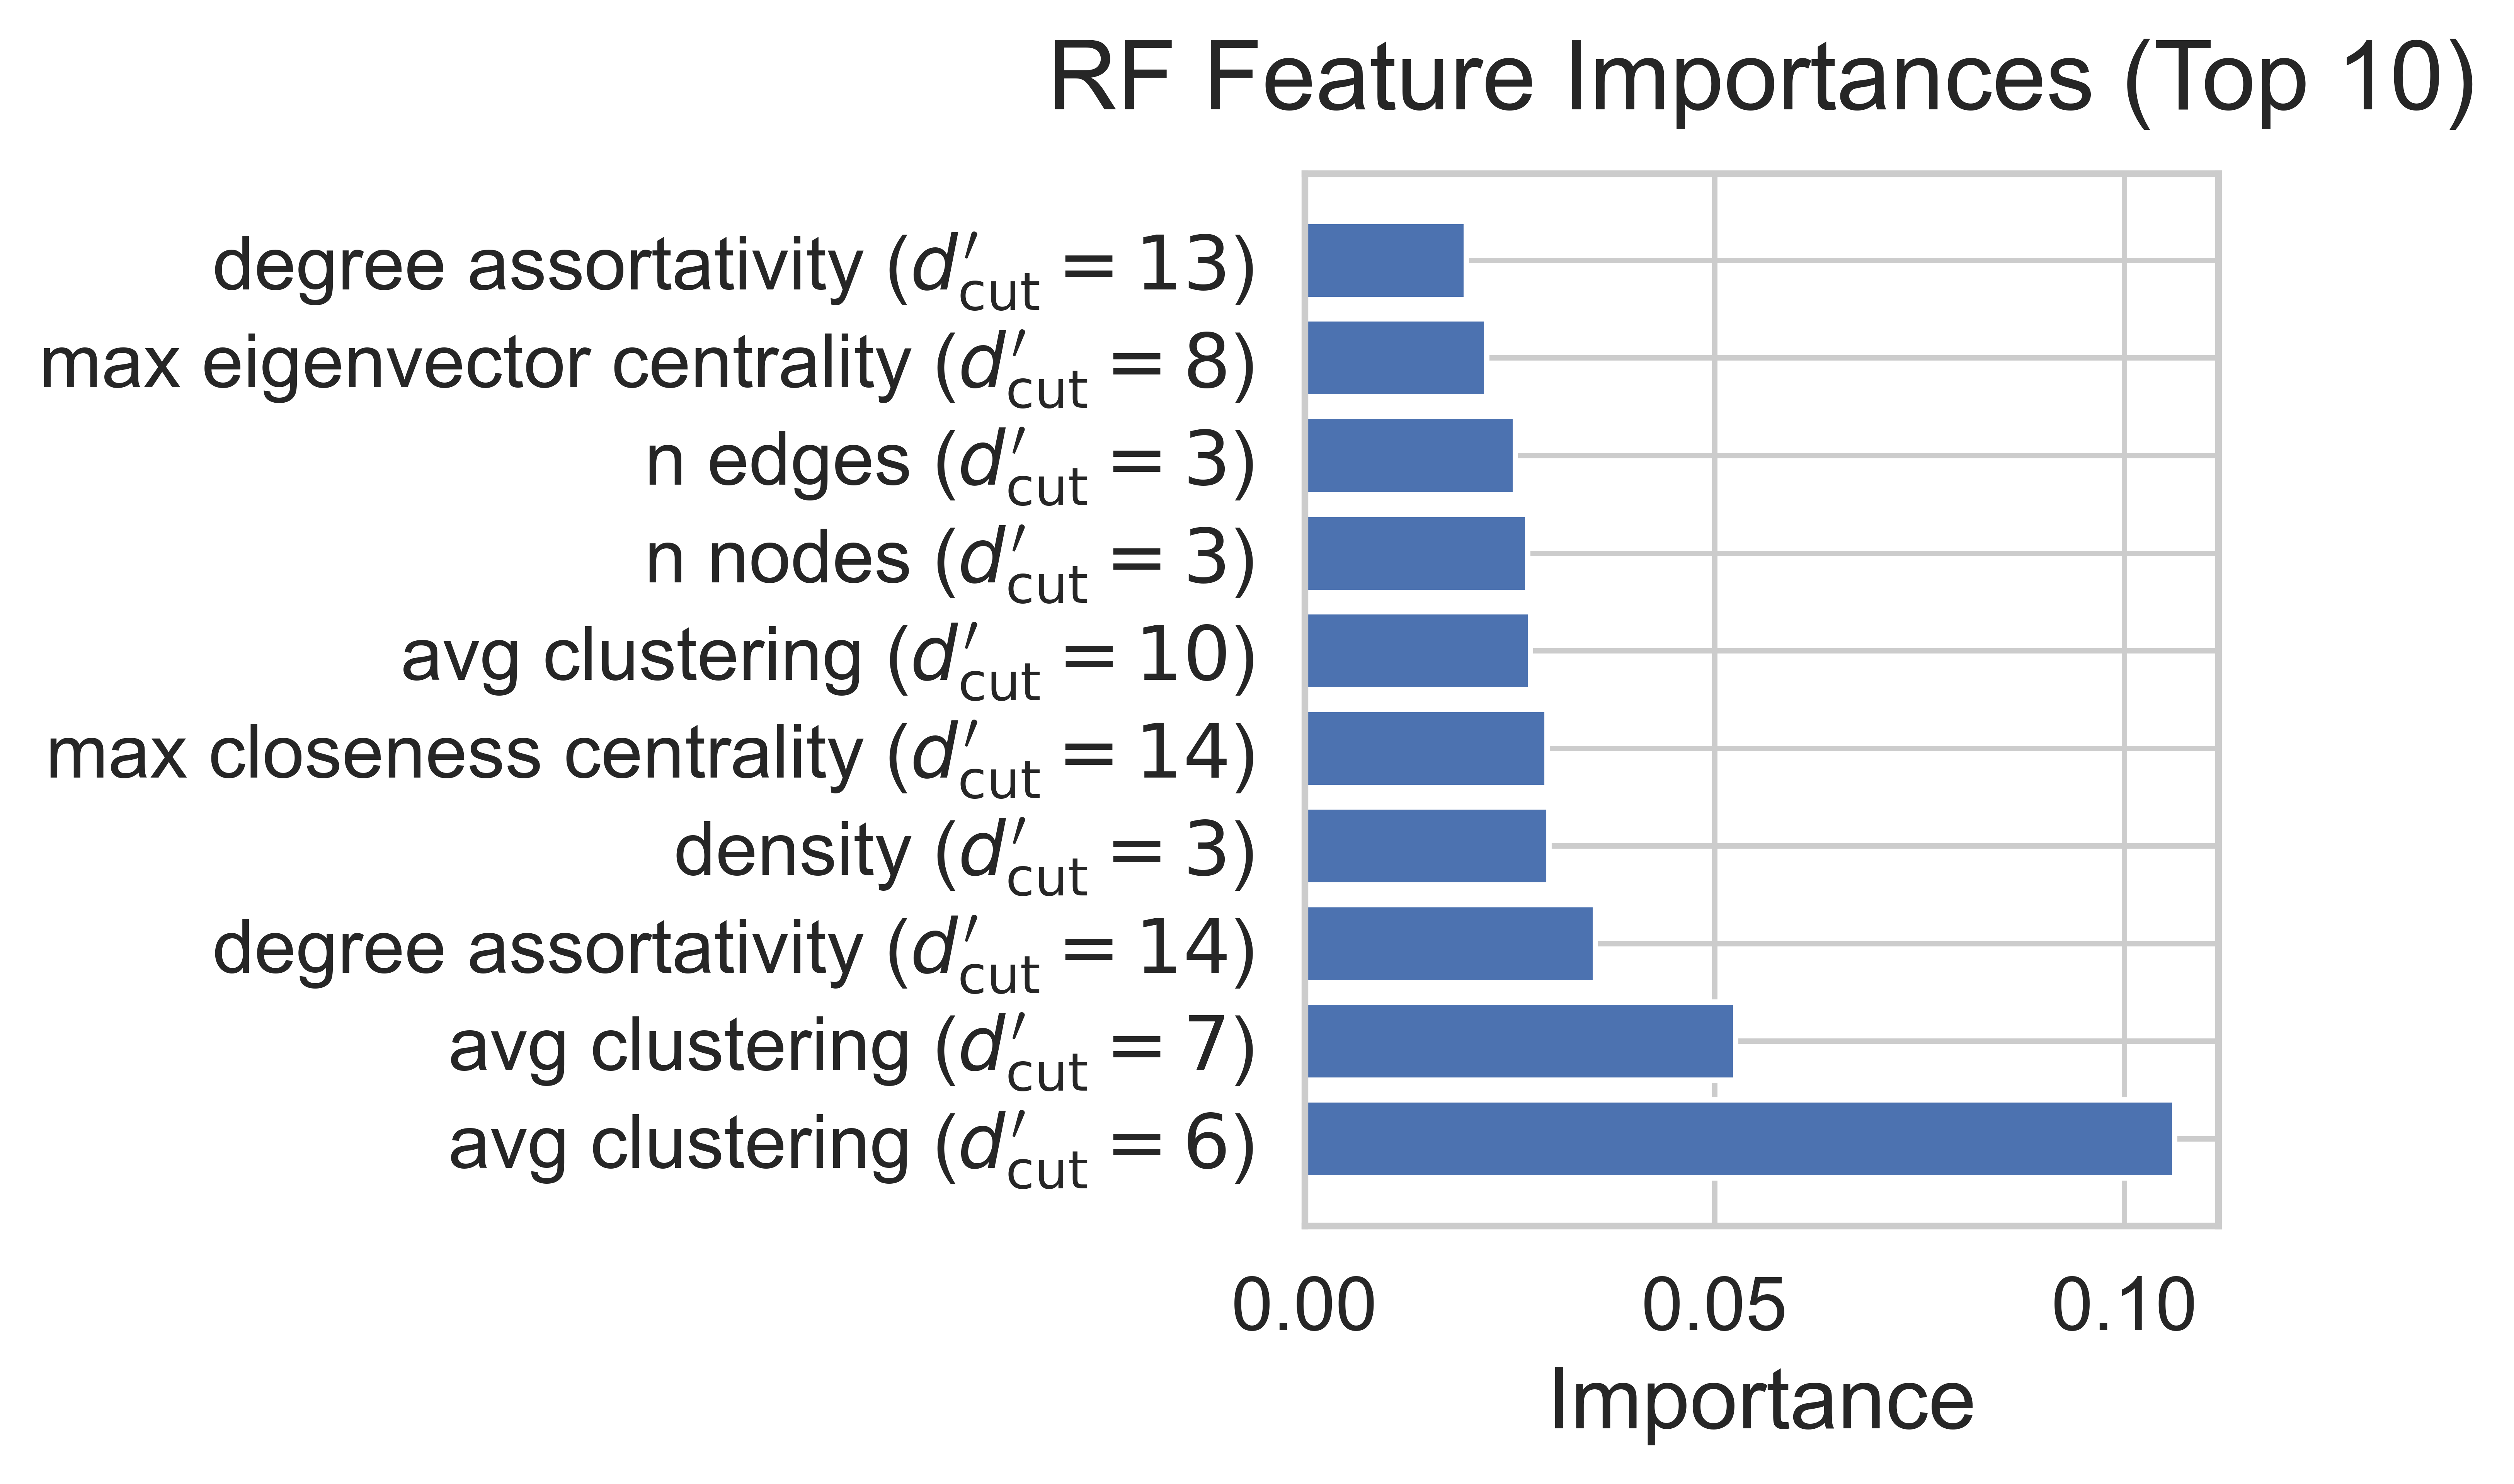

In [24]:
# Metrics including accuracy, F1-score, confusion matrix and feature importance, etc

# accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
# weighted F1-score
f1_rf  = f1_score(y_test, y_pred_rf, average='weighted')
# Print performance
print("=== Random Forest ===")
print(f"Accuracy:    {acc_rf:.4f}")
print(f"Weighted F1: {f1_rf:.4f}\n")
print(classification_report(y_test, y_pred_rf))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)
classes = rf.classes_
n = len(classes)

fig, ax = plt.subplots(figsize=(5,5), dpi=dpi)
for i in range(n):
    for j in range(n):
        face = 'black' if i==j else 'white'
        txtc = 'white' if i==j else 'black'
        rect = plt.Rectangle((j, i), 1, 1, facecolor=face, edgecolor='black')
        ax.add_patch(rect)
        ax.text(j+0.5, i+0.5, cm[i,j],
                ha='center', va='center', color=txtc, fontsize=16)
# ticks & labels
ax.set_xticks(np.arange(n)+0.5)
ax.set_yticks(np.arange(n)+0.5)
ax.set_xticklabels(classes, fontsize=20)
ax.set_yticklabels(classes, fontsize=20)
ax.set_xlim(0, n)
ax.set_ylim(n, 0)
ax.set_xlabel('Predicted', fontsize=20)
ax.set_ylabel('Actual', fontsize=20)
ax.set_title('RF Confusion Matrix', fontsize=18, pad=12)
plt.tight_layout()
plt.savefig('./rf_confusion_matrix.png', dpi=dpi)
plt.close()

# Plot feature importance
importances = rf.feature_importances_
idxs = np.argsort(importances)[::-1][:top_n]

def prettify_feature_name(name):
    match = re.search(r'(.*)_cutoff_(\d+)', name)
    if match:
        base, dcut = match.groups()
        return fr"{base} ($d_{{\mathrm{{cut}}}}^{{\prime}}={dcut}$)"
    else:
        return name

pretty_names = [prettify_feature_name(features[i]) for i in idxs]

fig, ax = plt.subplots(figsize=(6,4), dpi=dpi)
ax.barh(range(top_n)[::-1], importances[idxs][::-1], align='center')
ax.set_yticks(range(top_n)[::-1])
ax.set_yticklabels(pretty_names[::-1], fontsize=14)
ax.set_xlabel('Importance', fontsize=16)
ax.set_title('RF Feature Importances (Top 10)', fontsize=18, pad=12)
ax.tick_params(axis='x', labelsize=14)
plt.tight_layout()
plt.savefig('./rf_feature_importance.png', dpi=dpi, bbox_inches='tight')
plt.show()
